<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## **Desafio 3: Modelo de lenguaje con tokenización por caracteres**

### Lucas Argento

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [30]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## 0. Datos


In [2]:
# descargar de textos.info
import urllib.request

# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs

In [7]:
book = "https://www.gutenberg.org/ebooks/11.txt.utf-8"

In [8]:
raw_html = urllib.request.urlopen(book)
raw_html = raw_html.read()

# Parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag <p>)
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text + ' '

# pasar todo el texto a minúscula
article_text = article_text.lower()

In [9]:
# en article text se encuentra el texto de todo el libro
article_text[:1000]

"the project gutenberg ebook of alice's adventures in wonderland\r\n    \r\nthis ebook is for the use of anyone anywhere in the united states and\r\nmost other parts of the world at no cost and with almost no restrictions\r\nwhatsoever. you may copy it, give it away or re-use it under the terms\r\nof the project gutenberg license included with this ebook or online\r\nat www.gutenberg.org. if you are not located in the united states,\r\nyou will have to check the laws of the country where you are located\r\nbefore using this ebook.\r\n\r\ntitle: alice's adventures in wonderland\r\n\r\nauthor: lewis carroll\r\n\r\nrelease date: june 27, 2008 [ebook #11]\r\n                most recently updated: june 26, 2025\r\n\r\nlanguage: english\r\n\r\ncredits: arthur dibianca and david widger\r\n\r\n\r\n*** start of the project gutenberg ebook alice's adventures in wonderland ***\r\n\r\n[illustration]\r\n\r\n\r\n\r\n\r\nalice’s adventures in wonderland\r\n\r\nby lewis carroll\r\n\r\nthe millennium f

### 0.1 Elegimos el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [10]:
# seleccionamos el tamaño de contexto
max_context_size = 100

In [11]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [12]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)

In [13]:
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

65

In [14]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

### 0.2  Tokenizacion

In [15]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

In [16]:
tokenized_text[:1000]

[56,
 1,
 33,
 37,
 47,
 31,
 48,
 18,
 33,
 59,
 56,
 37,
 19,
 2,
 56,
 33,
 34,
 14,
 33,
 31,
 19,
 37,
 33,
 14,
 48,
 48,
 26,
 37,
 48,
 39,
 37,
 16,
 15,
 57,
 59,
 33,
 62,
 6,
 37,
 16,
 12,
 54,
 33,
 34,
 56,
 2,
 31,
 33,
 6,
 37,
 57,
 34,
 37,
 25,
 48,
 34,
 12,
 33,
 31,
 15,
 16,
 34,
 12,
 38,
 60,
 37,
 37,
 37,
 37,
 38,
 60,
 56,
 1,
 57,
 6,
 37,
 33,
 14,
 48,
 48,
 26,
 37,
 57,
 6,
 37,
 39,
 48,
 31,
 37,
 56,
 1,
 33,
 37,
 2,
 6,
 33,
 37,
 48,
 39,
 37,
 16,
 34,
 0,
 48,
 34,
 33,
 37,
 16,
 34,
 0,
 25,
 1,
 33,
 31,
 33,
 37,
 57,
 34,
 37,
 56,
 1,
 33,
 37,
 2,
 34,
 57,
 56,
 33,
 12,
 37,
 6,
 56,
 16,
 56,
 33,
 6,
 37,
 16,
 34,
 12,
 38,
 60,
 17,
 48,
 6,
 56,
 37,
 48,
 56,
 1,
 33,
 31,
 37,
 47,
 16,
 31,
 56,
 6,
 37,
 48,
 39,
 37,
 56,
 1,
 33,
 37,
 25,
 48,
 31,
 15,
 12,
 37,
 16,
 56,
 37,
 34,
 48,
 37,
 59,
 48,
 6,
 56,
 37,
 16,
 34,
 12,
 37,
 25,
 57,
 56,
 1,
 37,
 16,
 15,
 17,
 48,
 6,
 56,
 37,
 34,
 48,
 37,
 31,
 33,
 6,
 

### 0.3 Organizando y estructurando el dataset

In [51]:
train_text = tokenized_text

In [52]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [53]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [24]:
X.shape

(150774, 100)

In [25]:
X[0,:10]

array([56,  1, 33, 37, 47, 31, 48, 18, 33, 59])

In [26]:
y[0,:10]

array([ 1, 33, 37, 47, 31, 48, 18, 33, 59, 56])

In [27]:
vocab_size = len(chars_vocab)

## 1. Definiendo Los Modelos

Definiremos 3 modelos en PyTorch para comparar su performance: celda de Elman (RNN basica), LSTM y GRU

In [88]:
import torch
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

class PerplexityEvaluator:
    """
    Evalúa la perplejidad promedio sobre el conjunto de validación.
    Usa CrossEntropyLoss directamente (coherente con el entrenamiento).
    Incluye early stopping y guardado del mejor modelo.
    """

    def __init__(self, X_val, y_val, model, device,
                 patience=5, save_path="best_model.pt", eval_batch_size=64):
        """
        X_val, y_val: tensores o arrays numpy del conjunto de validación
        model: instancia del modelo PyTorch
        device: torch.device("cuda" o "cpu")
        patience: epochs sin mejora antes de early stopping
        save_path: ruta para guardar el mejor modelo
        eval_batch_size: tamaño de batch en validación
        """
        # convertir arrays numpy a tensores si es necesario
        if isinstance(X_val, np.ndarray):
            X_val = torch.tensor(X_val, dtype=torch.long)
        if isinstance(y_val, np.ndarray):
            y_val = torch.tensor(y_val, dtype=torch.long)

        self.inputs = X_val
        self.targets = y_val
        self.model = model.to(device)
        self.device = device
        self.patience = patience
        self.save_path = save_path
        self.eval_batch_size = eval_batch_size

        self.min_score = np.inf
        self.patience_counter = 0
        self.history_ppl = []

    def compute_perplexity(self):
        """Evalúa la perplejidad promedio en batches."""
        self.model.eval()
        total_loss = 0.0
        total_tokens = 0
        criterion = torch.nn.CrossEntropyLoss(reduction="sum")

        dataset = TensorDataset(self.inputs, self.targets)
        loader = DataLoader(dataset, batch_size=self.eval_batch_size, shuffle=False)

        with torch.no_grad():
            for X_batch, y_batch in loader:
                X_batch = X_batch.to(self.device)
                y_batch = y_batch.to(self.device)

                try:
                    outputs, _ = self.model(X_batch)
                except RuntimeError as e:
                    if "out of memory" in str(e).lower():
                        print("⚠️ GPU sin memoria — evaluando perplejidad en CPU temporalmente.")
                        torch.cuda.empty_cache()
                        self.model.to("cpu")
                        X_batch = X_batch.to("cpu")
                        y_batch = y_batch.to("cpu")
                        outputs, _ = self.model(X_batch)
                        self.model.to(self.device)
                    else:
                        raise e

                loss = criterion(outputs.view(-1, self.model.fc.out_features),
                                 y_batch.view(-1))
                total_loss += loss.item()
                total_tokens += y_batch.numel()

        mean_loss = total_loss / total_tokens
        ppl = np.exp(mean_loss)
        return ppl

    def on_epoch_end(self, epoch):
        """Calcula perplejidad, guarda modelo si mejora y aplica early stopping."""
        ppl = self.compute_perplexity()
        self.history_ppl.append(ppl)
        print(f"Epoch {epoch+1} — Mean Perplexity: {ppl:.3f}")

        if ppl < self.min_score:
            self.min_score = ppl
            self.patience_counter = 0
            torch.save(self.model.state_dict(), self.save_path)
            print("✅ Saved new best model.")
        else:
            self.patience_counter += 1
            if self.patience_counter >= self.patience:
                print("⛔ Early stopping triggered.")
                return True
        return False


### 1.1 SimpleRNN

In [89]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleRNNLanguageModel(nn.Module):
    def __init__(self, vocab_size, hidden_size=200, emb_dim=128, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size

        # embedding para reemplazar one-hot
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=emb_dim)

        self.rnn = nn.RNN(
            input_size=emb_dim,
            hidden_size=hidden_size,
            batch_first=True,
            dropout=dropout
        )

        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        # x: [batch, seq_len]
        x_emb = self.embedding(x)             # [batch, seq_len, emb_dim]
        out, hidden = self.rnn(x_emb, hidden) # [batch, seq_len, hidden_size]
        logits = self.fc(out)                 # [batch, seq_len, vocab_size]
        return logits, hidden


### 1.2 LSTM

In [90]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset

class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, hidden_size=200, dropout=0.1):
        super().__init__()
        self.rnn = nn.LSTM(vocab_size, hidden_size, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)
    def forward(self, x, hidden=None):
        x = F.one_hot(x, num_classes=self.fc.out_features).float()
        out, hidden = self.rnn(x, hidden)
        return self.fc(out), hidden


### 1.3 GRU

In [91]:
class GRULanguageModel(nn.Module):
    def __init__(self, vocab_size, hidden_size=200, dropout=0.1):
        super().__init__()
        self.rnn = nn.GRU(vocab_size, hidden_size, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)
    def forward(self, x, hidden=None):
        x = F.one_hot(x, num_classes=self.fc.out_features).float()
        out, hidden = self.rnn(x, hidden)
        return self.fc(out), hidden

## 2. Entrenamiento de los modelos

In [95]:
def train_model(model, train_loader, val_data, device, vocab_size,
                max_context_size,
                n_epochs=20, lr=0.001, patience=5, model_name="model"
                ):
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    evaluator = PerplexityEvaluator(
        X_val, y_val,
        model=model,
        device=device,
        patience=5,
        save_path=f"{model_name}_best.pt",
        eval_batch_size=32
    )

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs, _ = model(X_batch)
            loss = criterion(outputs.view(-1, vocab_size), y_batch.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"\nEpoch {epoch+1}/{n_epochs} — Loss: {avg_loss:.4f}")

        # Calcular perplejidad y chequear early stopping
        stop = evaluator.on_epoch_end(epoch)
        if stop:
            print(f"Entrenamiento detenido en epoch {epoch+1} (early stopping).")
            break

    # 🔹 Guardar el modelo final (último epoch entrenado)
    final_path = f"{model_name}_final.pt"
    torch.save(model.state_dict(), final_path)
    print(f"Modelo final guardado en: {final_path}")
    print(f"Mejor modelo guardado en: {model_name}_best.pt")

    return evaluator.history_ppl, model


In [96]:
print("- Vocab size: ", vocab_size)
print("- Context Len:", max_context_size)


- Vocab size:  65
- Context Len: 100


In [97]:
EPOCHS = 20
LR = 0.001
PATIENCE = 5

seq_len = max_context_size

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42
)

X_train_t = torch.tensor(X_train, dtype=torch.long)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_val_t   = torch.tensor(X_val, dtype=torch.long)
y_val_t   = torch.tensor(y_val, dtype=torch.long)

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset   = TensorDataset(X_val_t, y_val_t)

# 4️⃣ DataLoaders (listas para tu loop)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)


# Datos de validación (listas de secuencias)
val_data = [seq.tolist() for seq in X_val_t]  # compatible con tu callback

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Entrenar los tres modelos
models = {
    "SimpleRNN": SimpleRNNLanguageModel(vocab_size),
    "LSTM": LSTMLanguageModel(vocab_size),
    "GRU": GRULanguageModel(vocab_size)
}

history = {}
for name, model in models.items():
    print(f"\n- Entrenando {name}...")
    model.to(device)
    history[name], model = train_model(
        model=model,
        train_loader=train_loader,
        val_data=val_data,
        device=device,
        vocab_size=vocab_size,
        n_epochs=EPOCHS,
        max_context_size=seq_len,
        lr=LR,
        patience=PATIENCE,
        model_name=name,
    )


- Entrenando SimpleRNN...

Epoch 1/20 — Loss: 1.2941
Epoch 1 — Mean Perplexity: 3.013
✅ Saved new best model.

Epoch 2/20 — Loss: 1.0425
Epoch 2 — Mean Perplexity: 2.737
✅ Saved new best model.

Epoch 3/20 — Loss: 0.9867
Epoch 3 — Mean Perplexity: 2.660
✅ Saved new best model.

Epoch 4/20 — Loss: 0.9677
Epoch 4 — Mean Perplexity: 2.614
✅ Saved new best model.

Epoch 5/20 — Loss: 0.9577
Epoch 5 — Mean Perplexity: 2.614
✅ Saved new best model.

Epoch 6/20 — Loss: 0.9522
Epoch 6 — Mean Perplexity: 2.607
✅ Saved new best model.

Epoch 7/20 — Loss: 0.9479
Epoch 7 — Mean Perplexity: 2.595
✅ Saved new best model.

Epoch 8/20 — Loss: 0.9445
Epoch 8 — Mean Perplexity: 2.596

Epoch 9/20 — Loss: 0.9415
Epoch 9 — Mean Perplexity: 2.573
✅ Saved new best model.

Epoch 10/20 — Loss: 0.9390
Epoch 10 — Mean Perplexity: 2.572
✅ Saved new best model.

Epoch 11/20 — Loss: 0.9363
Epoch 11 — Mean Perplexity: 2.564
✅ Saved new best model.

Epoch 12/20 — Loss: 0.9348
Epoch 12 — Mean Perplexity: 2.547
✅ Saved

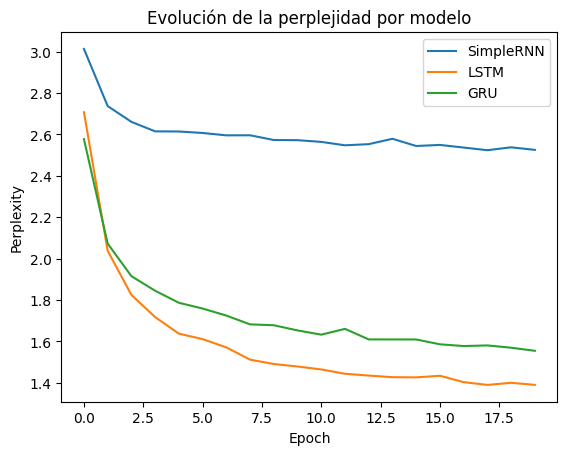

In [98]:
import matplotlib.pyplot as plt

for name, h in history.items():
    plt.plot(h, label=name)
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.legend()
plt.title("Evolución de la perplejidad por modelo")
plt.show()


## 3. Predicción del próximo caracter

In [99]:
!pip install -q gradio

In [100]:
def load_model(model_type):
    """
    Carga el modelo seleccionado desde su archivo *_best.pt.
    """
    model_map = {
        "SimpleRNN": SimpleRNNLanguageModel,
        "LSTM": LSTMLanguageModel,
        "GRU": GRULanguageModel
    }
    model_class = model_map[model_type]
    model = model_class(vocab_size=len(char2idx))
    model_path = f"{model_type}_best.pt"
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.to(device)
        model.eval()
        print(f"✅ Modelo {model_type} cargado desde {model_path}")
    except FileNotFoundError:
        print(f"⚠️ No se encontró el archivo {model_path}. Asegurate de haberlo entrenado.")
        model = None
    return model

In [101]:
def pad_sequence_np(seq, maxlen, pad_value=0):
    seq = np.array(seq)
    if len(seq) < maxlen:
        pad = np.full(maxlen - len(seq), pad_value)
        return np.concatenate([pad, seq])
    else:
        return seq[-maxlen:]

def model_response(human_text, model_type):
    if len(human_text.strip()) == 0:
        return ""

    model = load_model(model_type)
    if model is None:
        return f"❌ No se encontró el modelo {model_type}_best.pt"

    # 1️⃣ Codificar el texto
    encoded = [char2idx.get(ch.lower(), 0) for ch in human_text]
    encoded = pad_sequence_np(encoded, max_context_size)
    encoded = torch.tensor(encoded, dtype=torch.long).unsqueeze(0).to(device)

    # 2️⃣ Inferencia
    with torch.no_grad():
        outputs, _ = model(encoded)
        logits = outputs[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        y_hat = torch.argmax(probs, dim=-1).item()

    # 3️⃣ Decodificar y devolver
    next_char = idx2char[y_hat]
    return human_text + next_char

In [103]:
import gradio as gr


iface = gr.Interface(
    fn=model_response,
    inputs=[
        gr.Textbox(label="Ingresa texto"),
        gr.Radio(["SimpleRNN", "LSTM", "GRU"], label="Seleccionar modelo", value="SimpleRNN")
    ],
    outputs=gr.Textbox(label="Predicción del modelo"),
    title="🧠 Generador de texto RNN/LSTM/GRU (PyTorch)",
    description="Seleccioná el modelo y generá el siguiente carácter predicho."
)

iface.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://34bfe93644808d25be.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


✅ Modelo SimpleRNN cargado desde SimpleRNN_best.pt


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


✅ Modelo SimpleRNN cargado desde SimpleRNN_best.pt


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


✅ Modelo LSTM cargado desde LSTM_best.pt


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


✅ Modelo GRU cargado desde GRU_best.pt
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://34bfe93644808d25be.gradio.live


### 3.1 Generación de secuencias

In [105]:
import torch
import torch.nn.functional as F
import numpy as np

def generate_seq(model, seed_text, max_length, n_words):
    """
    Genera texto autoregresivamente con un modelo PyTorch.
    Args:
        model (torch.nn.Module): modelo entrenado (SimpleRNN, LSTM o GRU)
        seed_text (str): texto de entrada (contexto inicial)
        max_length (int): longitud máxima de la secuencia de entrada (contexto)
        n_words (int): cantidad de caracteres a generar
    Returns:
        str: texto generado (semilla + predicciones)
    """
    model.eval()
    output_text = seed_text

    for _ in range(n_words):
        # 1️⃣ Encodear texto actual
        encoded = [char2idx.get(ch.lower(), 0) for ch in output_text]
        if len(encoded) < max_length:
            pad = [0] * (max_length - len(encoded))
            encoded = pad + encoded
        else:
            encoded = encoded[-max_length:]

        # Convertir a tensor
        x = torch.tensor(encoded, dtype=torch.long).unsqueeze(0).to(device)

        # 2️⃣ Forward pass
        with torch.no_grad():
            outputs, _ = model(x)
            logits = outputs[:, -1, :]  # solo el último paso temporal
            probs = F.softmax(logits, dim=-1)
            y_hat = torch.argmax(probs, dim=-1).item()

        # 3️⃣ Decodificar y agregar carácter
        out_char = idx2char[y_hat]
        output_text += out_char

    return output_text

In [109]:
def model_response(seed_text, model_type, n_chars):
    model = load_model(model_type)
    generated = generate_seq(model, seed_text, max_context_size, int(n_chars))
    return generated


iface = gr.Interface(
    fn=model_response,
    inputs=[
        gr.Textbox(label="Texto inicial (semilla)", placeholder="Escribí un inicio..."),
        gr.Radio(["SimpleRNN", "LSTM", "GRU"], label="Seleccionar modelo", value="SimpleRNN"),
        gr.Slider(1, 200, value=50, step=1, label="Cantidad de caracteres a generar")
    ],
    outputs=gr.Textbox(label="Texto generado"),
    title="🧠 Generador de texto con RNN / LSTM / GRU (PyTorch)",
    description="Seleccioná un modelo y generá texto autoregresivamente."
)

iface.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://3a0951aa0e6dfc9649.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


✅ Modelo SimpleRNN cargado desde SimpleRNN_best.pt


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


✅ Modelo LSTM cargado desde LSTM_best.pt


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


✅ Modelo GRU cargado desde GRU_best.pt


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


✅ Modelo GRU cargado desde GRU_best.pt


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


✅ Modelo LSTM cargado desde LSTM_best.pt


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


✅ Modelo SimpleRNN cargado desde SimpleRNN_best.pt


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


✅ Modelo SimpleRNN cargado desde SimpleRNN_best.pt


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


✅ Modelo LSTM cargado desde LSTM_best.pt


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


✅ Modelo GRU cargado desde GRU_best.pt


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


✅ Modelo GRU cargado desde GRU_best.pt
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://3a0951aa0e6dfc9649.gradio.live


> **Análisis:** Notamos que en todos los casos (los 3 modelos) se refleja informacion aprendida del libro utilizado como dataset (alice in wonderland), pero no se generan oraciones ni palabras coherentes!

###  3.2 Beam search y muestreo aleatorio

In [115]:
import torch
import numpy as np
from scipy.special import softmax

# -----------------------------------------------------------
# ENCODE / DECODE
# -----------------------------------------------------------

def encode(text, max_length=max_context_size):
    """Codifica texto en tensores PyTorch con padding previo."""
    encoded = [char2idx.get(ch, 0) for ch in text.lower()]
    if len(encoded) < max_length:
        pad = [0] * (max_length - len(encoded))
        encoded = pad + encoded
    else:
        encoded = encoded[-max_length:]
    x = torch.tensor(encoded, dtype=torch.long).unsqueeze(0).to(device)
    return x

def decode(seq):
    """Convierte una secuencia de índices en texto."""
    return ''.join([idx2char[i] for i in seq])

# -----------------------------------------------------------
# SELECT CANDIDATES
# -----------------------------------------------------------

def select_candidates(preds, num_beams, vocab_size, history_probs, history_tokens, temp, mode):
    """
    Selecciona los mejores candidatos del beam actual.
    preds: lista de arrays (num_beams × vocab_size)
    """
    pred_large = []

    for idx, pp in enumerate(preds):
        pred_large.extend(np.log(pp + 1e-10) + history_probs[idx])

    pred_large = np.array(pred_large)

    # Criterio de selección
    if mode == 'det':
        idx_select = np.argsort(pred_large)[::-1][:num_beams]
    elif mode == 'sto':
        idx_select = np.random.choice(
            np.arange(pred_large.shape[0]),
            num_beams,
            p=softmax(pred_large / temp)
        )
    else:
        raise ValueError(f"Wrong selection mode '{mode}'. Use 'det' or 'sto'.")

    # Indices reales
    new_history_tokens = np.concatenate(
        (np.array(history_tokens)[idx_select // vocab_size],
         np.array([idx_select % vocab_size]).T),
        axis=1
    )

    return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


# -----------------------------------------------------------
# BEAM SEARCH (PyTorch version)
# -----------------------------------------------------------

def beam_search(model, num_beams, num_words, input_text, temp=1, mode='det'):
    """
    Implementación de beam search usando un modelo PyTorch.
    Devuelve TODAS las secuencias generadas + la mejor.
    """
    model.eval()

    # 1️⃣ Primera iteración
    encoded = encode(input_text)
    with torch.no_grad():
        outputs, _ = model(encoded)
        y_hat = torch.softmax(outputs[:, -1, :], dim=-1).cpu().numpy()[0]

    vocab_size = y_hat.shape[0]

    # Inicialización
    history_probs = np.zeros(num_beams)
    history_tokens = [encoded.cpu().numpy()[0]] * num_beams

    # Selección inicial
    history_probs, history_tokens = select_candidates(
        [y_hat], num_beams, vocab_size,
        history_probs, history_tokens, temp, mode
    )

    # 2️⃣ Loop de búsqueda
    for _ in range(num_words - 1):
        preds = []
        for hist in history_tokens:
            input_update = torch.tensor([hist[-max_context_size:]], dtype=torch.long).to(device)
            with torch.no_grad():
                outputs, _ = model(input_update)
                y_hat = torch.softmax(outputs[:, -1, :], dim=-1).cpu().numpy()[0]
            preds.append(y_hat)

        history_probs, history_tokens = select_candidates(
            preds, num_beams, vocab_size,
            history_probs, history_tokens, temp, mode
        )

    # 3️⃣ Ranking final
    ranked_indices = np.argsort(history_probs)[::-1]
    ranked_probs = history_probs[ranked_indices]
    ranked_tokens = history_tokens[ranked_indices]

    # 4️⃣ Decodificación
    decoded_sequences = [
        decode(seq[-(len(input_text) + num_words):]) for seq in ranked_tokens
    ]

    # 5️⃣ Empaquetado de resultados
    results = [
        {"rank": i + 1,
         "log_prob": float(ranked_probs[i]),
         "text": decoded_sequences[i]}
        for i in range(len(decoded_sequences))
    ]

    best_seq = decoded_sequences[0]
    return best_seq, results


In [120]:
# Texto semilla
seed = "Alice "

# Beam search determinista
best, beams = beam_search(model, num_beams=5, num_words=50, input_text=seed, mode="det")

print("🏆 Mejor beam:")
print(best)

print("\n🔍 Otros candidatos:")
for b in beams:
    print(f"[{b['rank']}] logP={b['log_prob']:.2f} → {b['text']}")

🏆 Mejor beam:
alice curiosion of the project gutenberg™ trademark. con

🔍 Otros candidatos:
[1] logP=-7.69 → alice curiosion of the project gutenberg™ trademark. con
[2] logP=-8.35 → alice curiosion of the project gutenberg™ trademark, and
[3] logP=-8.96 → alice curiosion of the project
gutenberg™ trademark, an
[4] logP=-9.33 → alice curiosion of the project
gutenberg™ trademark. co
[5] logP=-10.85 → alice curiosion of the project gutenberg™ trademark. cun


In [121]:
# Texto semilla
seed = "Alice"

# Beam search determinista
best, beams = beam_search(model, num_beams=5, num_words=50, input_text=seed, mode="sto")

print("🏆 Mejor beam:")
print(best)

print("\n🔍 Otros candidatos:")
for b in beams:
    print(f"[{b['rank']}] logP={b['log_prob']:.2f} → {b['text']}")

🏆 Mejor beam:
aliced,” said the king.

here one of the project gute

🔍 Otros candidatos:
[1] logP=-8.42 → aliced,” said the king.

here one of the project gute
[2] logP=-8.42 → aliced,” said the king.

here one of the project gute
[3] logP=-8.42 → aliced,” said the king.

here one of the project gute
[4] logP=-8.42 → aliced,” said the king.

here one of the project gute
[5] logP=-8.42 → aliced,” said the king.

here one of the project gute
